In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import logging

%matplotlib inline
warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO)
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Descarga Datos desde Kaggle

In [3]:
#https://www.kaggle.com/datasets/luisfelipetn/valor-casas-usadas-chile-rm-08032023
#!kaggle datasets download -d luisfelipetn/valor-casas-usadas-chile-rm-08032023
#!unzip valor-casas-usadas-chile-rm-08032023.zip

### Carga CSV

In [4]:
df_casas=pd.read_csv('2023-07-18 Propiedades Web Scrape.csv')

In [5]:
df_casas

,Price_CLP,Price_UF,Price_USD,Comuna,Ubicacion,Dorms,Baths,Built Area,Total Area,Parking,id,Realtor
0,129884400,3600.0,158396.0,Lampa,AvenidaLaHacienda,3.0,2.0,68.0,221.0,1.0,7850612,Behouse
1,130000000,3603.0,158537.0,Buin,Villaseca,5.0,3.0,150.0,190.0,2.0,10081485,NaN
2,172998805,4795.0,210974.0,PuenteAlto,BarrioAustria,4.0,3.0,90.0,182.0,3.0,10257247,Bissac
3,135296250,3750.0,164995.0,Buin,ComercianteArmandoPérezCarrasco,3.0,2.0,85.0,175.0,1.0,20153043,Ambiento Propiedades
4,195000000,5405.0,237805.0,QuintaNormal,Hostos,3.0,3.0,130.0,402.0,1.0,16669338,Puntoinmobiliario.cl
...,...,...,...,...,...,...,...,...,...,...,...,...
9286,80000000,2217.0,97561.0,PuenteAlto,LasAvestruces0352,2.0,1.0,75.0,100.0,2.0,7817190,Margarita Leiva Catalan
9287,250000000,6929.0,304878.0,PuenteAlto,manuelrodriguez,4.0,2.0,196.0,750.0,NaN,7650477,Margarita Leiva Catalan
9288,3788295000,105000.0,4619872.0,LasCondes,CaminoLasFlores/CaminoPiedraRoja,5.0,7.0,460.0,4925.0,8.0,6032811,Tsi Property
9289,577264000,16000.0,703980.0,LaPintana,LosCipreses/LosDuraznos,4.0,2.0,311.0,2011.0,1.0,5314376,Tsi Property


### Selección de Variables

In [7]:
df_casas=pd.get_dummies(df_casas,columns=['Comuna'],drop_first=True)

In [8]:
df_casas=df_casas.drop(columns=['Ubicacion','id','Realtor','Price_CLP','Price_USD'],axis=1)

### EDA

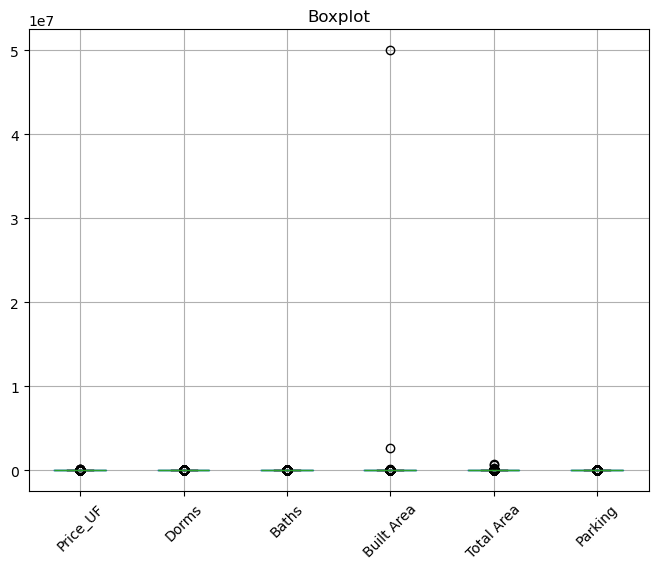

In [9]:
# Análisis de Outliers
df_casas.iloc[:,:6].boxplot(figsize=(8, 6))
plt.title('Boxplot')
plt.xticks(rotation=45)
plt.show()

In [10]:
#Se eliminan NaNs y Outliers
df_casas.dropna(how='any',inplace=True)
df_casas=df_casas[(df_casas['Total Area']<250000) & (df_casas['Built Area']<300000)]

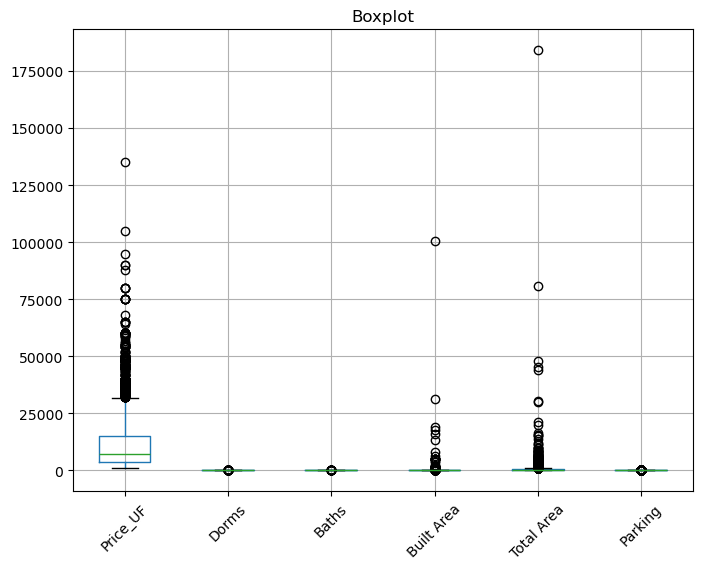

In [11]:
df_casas.iloc[:,:6].boxplot(figsize=(8, 6))
plt.title('Boxplot')
plt.xticks(rotation=45)
plt.show()

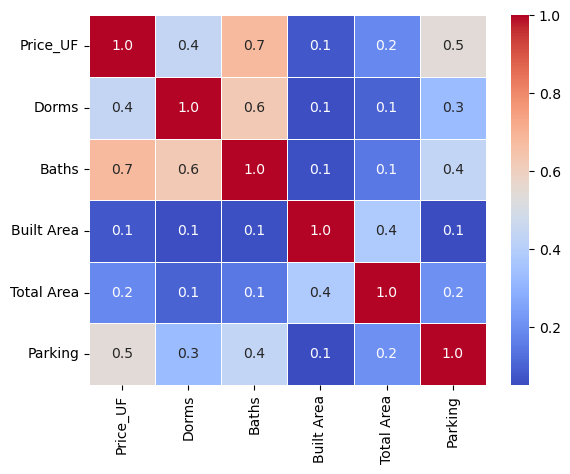

In [12]:
sns.heatmap(df_casas.iloc[:,:6].corr(),annot=True,fmt=".1f",cmap='coolwarm',linewidths=0.5)
plt.show()

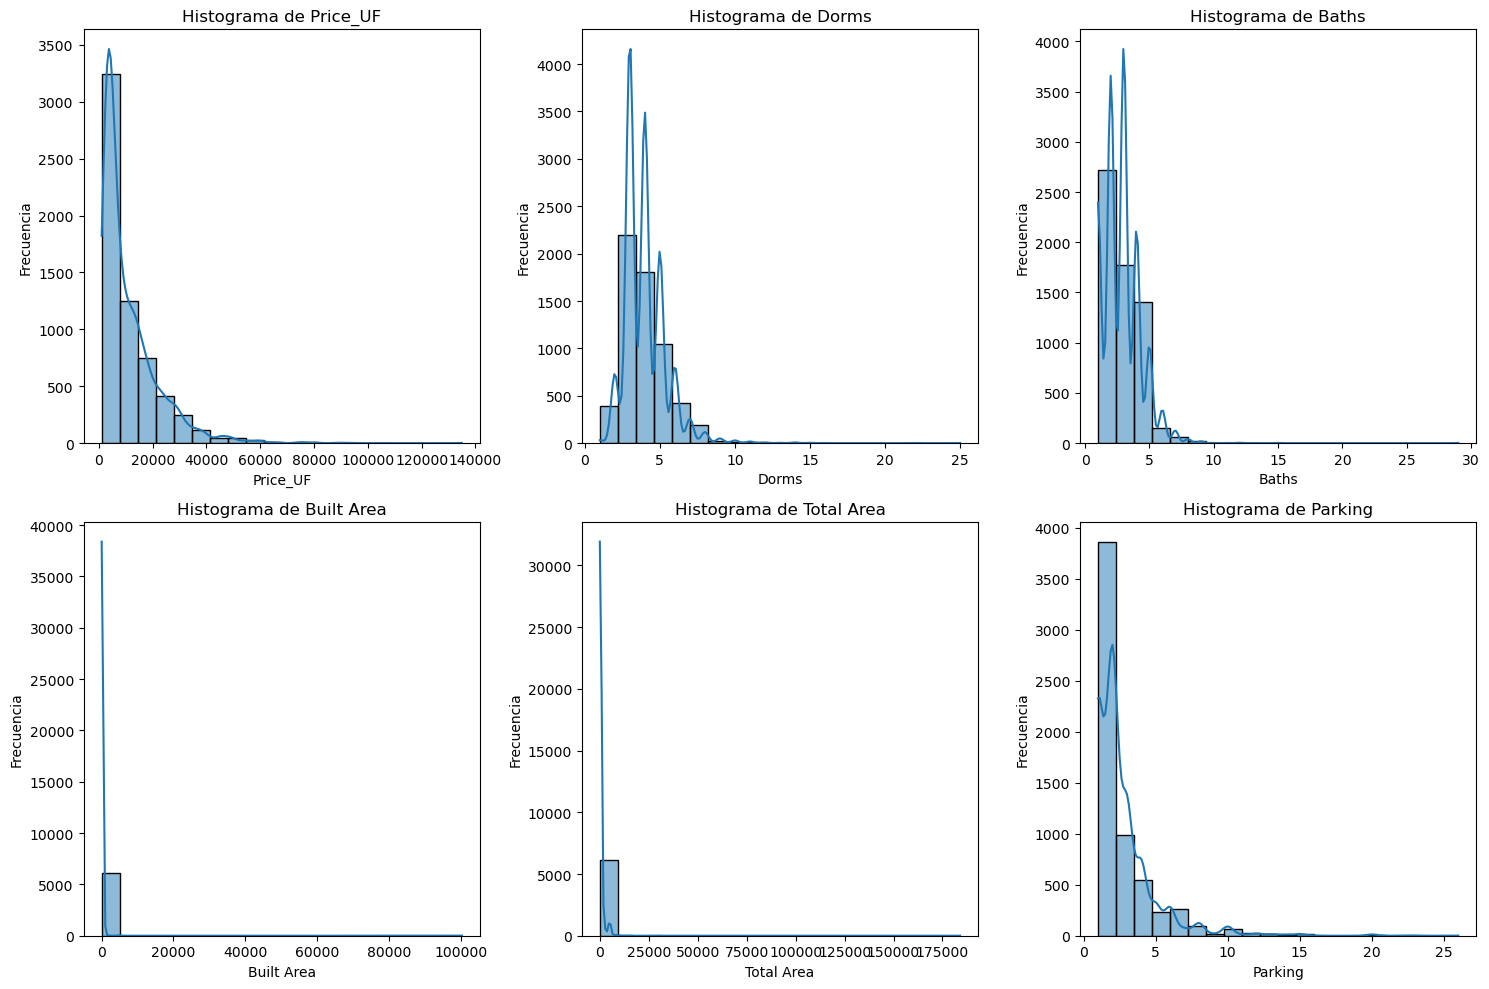

In [13]:
ncols=3
nrows=2
subset=df_casas.iloc[:,:6]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows),tight_layout=True)

axes = axes.flatten()  

for i, column in enumerate(subset.columns):
    sns.histplot(subset[column], ax=axes[i], kde=True,bins=20,palette='tab10')
    axes[i].set_title(f'Histograma de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frecuencia')


In [14]:
#Transformación logarítmica de la variable objetivo
df_casas['Price_UF'] = np.log(df_casas['Price_UF'])

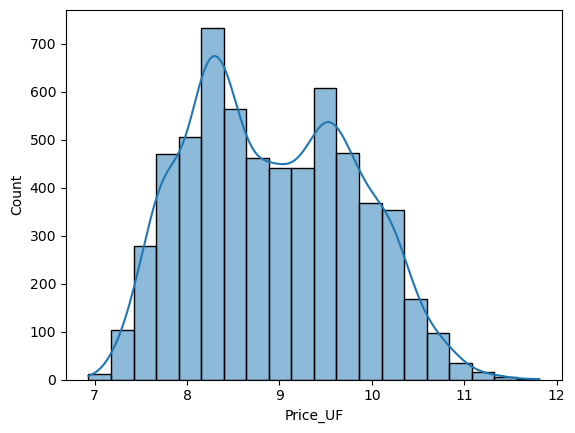

In [15]:
sns.histplot(df_casas['Price_UF'], kde=True,bins=20,palette='tab10')
plt.show()

### Aplicación de Modelos de Regresión

In [16]:
y=df_casas['Price_UF']
X=df_casas
del X['Price_UF']

In [34]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [35]:
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
                            }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.1, 0.5, 0.9],
            'fit_intercept': [True, False]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10],
            'fit_intercept': [True, False]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1, 10],
            'fit_intercept': [True, False]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion': ['mse', 'friedman_mse', 'mae'],
            'splitter': ['best', 'random']
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'criterion': ['squared_error', 'absolute_error','friedman_mse']
        }
    },

    'KNeighborsRegressor':{
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors':[3,5,6,10],
            'weights':['uniform','distance'],
            'metric':['cosine','euclidean','manhattan']
        }

    },
    'GradientBoostingRegressor':{
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'criterion': ['squared_error', 'friedman_mse']
        }

    },
    'XGBoostRegressor':{
        'model': xgb.XGBRegressor(objective='reg:squarederror'),
        'params': {'n_estimators': [100, 300, 500],
                   'learning_rate': [0.01, 0.1, 0.2],
                   'max_depth': [3, 5, 7],
                   'subsample': [0.7, 0.8, 0.9],
                   'colsample_bytree': [0.7, 0.8, 1.0],
                   'min_child_weight': [1, 3, 5],
                   'reg_alpha': [0, 0.1, 0.5],
                   'reg_lambda': [0.1, 0.5, 1.0]
        }
    }
    
}


In [36]:
sc=StandardScaler()
X_train_sc=sc.fit_transform(X_train)
X_test_sc=sc.transform(X_test)

In [37]:
results=[]
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'}

for model_name, model in models.items():

  grid = GridSearchCV(model['model'], model['params'], cv=5, scoring=scoring,n_jobs=-1,refit='R2')
  grid.fit(X_train_sc, y_train)
  logging.info(f'Modelo {model_name} terminado')

  results.append({
      'Modelo': model_name,
      'Best_Estimator': grid.best_estimator_,
      'Best_Params': grid.best_params_,
      'Best_R2_Score': grid.best_score_,
      'Best_MAE': -grid.cv_results_['mean_test_MAE'][grid.best_index_],  
      'Best_MSE': -grid.cv_results_['mean_test_MSE'][grid.best_index_] })

results_df=pd.DataFrame(results)


INFO:root:Modelo LinearRegression terminado
INFO:root:Modelo ElasticNet terminado
INFO:root:Modelo Ridge terminado
INFO:root:Modelo Lasso terminado
INFO:root:Modelo DecisionTree terminado
INFO:root:Modelo RandomForest terminado
INFO:root:Modelo KNeighborsRegressor terminado
INFO:root:Modelo GradientBoostingRegressor terminado
INFO:root:Modelo XGBoostRegressor terminado


In [75]:
results_df

,Modelo,Best_Estimator,Best_Params,Best_R2_Score,Best_MAE,Best_MSE
0,LinearRegression,LinearRegression(),{'fit_intercept': True},0.784541,0.291863,0.168329
1,ElasticNet,"ElasticNet(alpha=0.1, l1_ratio=0.1)","{'alpha': 0.1, 'fit_intercept': True, 'l1_rati...",0.790466,0.303480,0.163567
2,Ridge,Ridge(alpha=10),"{'alpha': 10, 'fit_intercept': True}",0.785195,0.291767,0.167812
3,Lasso,Lasso(alpha=0.1),"{'alpha': 0.1, 'fit_intercept': True}",0.644112,0.426677,0.277566
4,DecisionTree,DecisionTreeRegressor(criterion='friedman_mse'...,"{'criterion': 'friedman_mse', 'splitter': 'ran...",0.820618,0.254519,0.139972
5,RandomForest,"(DecisionTreeRegressor(max_features=1.0, rando...","{'criterion': 'squared_error', 'n_estimators':...",0.891762,0.200940,0.084505
6,KNeighborsRegressor,"KNeighborsRegressor(metric='manhattan', n_neig...","{'metric': 'manhattan', 'n_neighbors': 6, 'wei...",0.848279,0.239734,0.118565
7,GradientBoostingRegressor,([DecisionTreeRegressor(criterion='friedman_ms...,"{'criterion': 'friedman_mse', 'n_estimators': ...",0.895722,0.207840,0.081423
8,XGBoostRegressor,"XGBRegressor(base_score=None, booster=None, ca...","{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.915010,0.185183,0.066387


### Clusterización de Variables usando K-Means

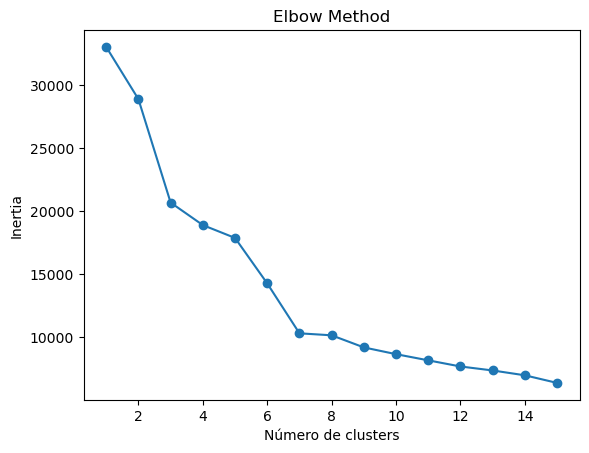

In [235]:
#leer los datos
df_casas=pd.read_csv('2023-07-18 Propiedades Web Scrape.csv')

#preprocesamiento
def preprocesamiento(df_original:pd.DataFrame)->pd.DataFrame:
    #Se eliminan NaNs y Outliers y se transforma la variable objetivo
    df_original.dropna(how='any',inplace=True)
    df_original=df_original[(df_original['Total Area']<250000) & (df_original['Built Area']<100000)]
    df_original=df_original.drop(columns=['Ubicacion','id','Realtor','Price_CLP','Price_USD'],axis=1)
    df_original['Price_UF'] = df_original['Price_UF'].apply(lambda x : np.log(x))
    
    #dummies de comunas

    return df_original

df_casas_preproc = preprocesamiento(df_casas)

# Vamos a hacer una clusteririzacion de los datos y observar si se pueden identificar grupos de propiedades y tambien si estos grupos se relacionan
# con las comunas de santiago
# Para ello vamos a utilizar KMeans para realizar una clusterizacion de los datos

X_cluster = df_casas_preproc.drop(columns=['Comuna'])
y = df_casas_preproc['Comuna']

sc=StandardScaler()
X_cluster_sc=sc.fit_transform(X_cluster)
df_cluster=pd.DataFrame(X_cluster_sc,columns=X_cluster.columns)

# No vamos a realizar una reducción de dimensionalidad ya que tenemos pocas columnas
from sklearn.cluster import KMeans

#almacenamos la inercia para construir la grafica del codo, para la eleccion de clusters

inertia=[]
for i in range(1,16):
    kmeans = KMeans(n_clusters=i,random_state=4431,max_iter=1000).fit(X_cluster_sc)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,16),inertia,marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [236]:
#re-entrenamos con los 7 clusters, cuando ya se estabiliza la inercia
kmeans = KMeans(n_clusters=7,random_state=4431,max_iter=1000).fit(X_cluster_sc)

In [237]:
# extraemos labels de clusters y centroides
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

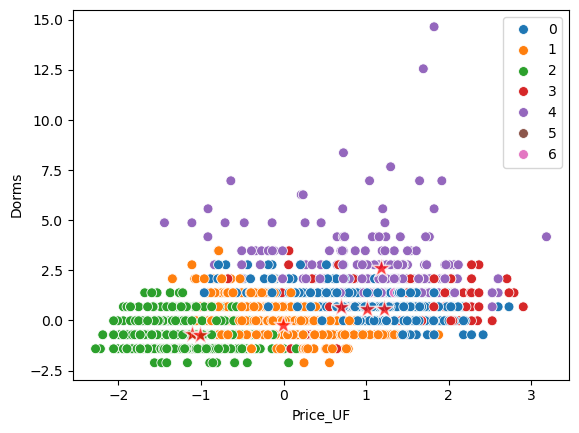

In [238]:
# dibujamos grafico de dispersion entre precio y dorms y usando como hue los clusters y tambien dibujando sus centroides.
sns.scatterplot(x=df_cluster.iloc[:,0],y=df_cluster.iloc[:,1] ,hue=labels, s=50,palette='tab10')
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], color='red', s=200, alpha=0.75, marker='*')
plt.show()


In [239]:
# mapear al dataset original los clusters

df_cluster['Cluster']=labels
df_cluster['Comuna']=y.to_numpy()

In [240]:
#observar clusters y precios medios y cuenta de casas.
df_cluster.groupby('Cluster').agg({'Price_UF':['mean','std','count']})

Price_UF                
             mean       std count
Cluster                          
0        1.010776  0.510913  1308
1       -0.008338  0.532453  2046
2       -1.104865  0.399282  1683
3        1.211920  0.731958   220
4        1.174373  0.774156   243
5       -1.008238       NaN     1
6        0.693452  0.687653     5

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


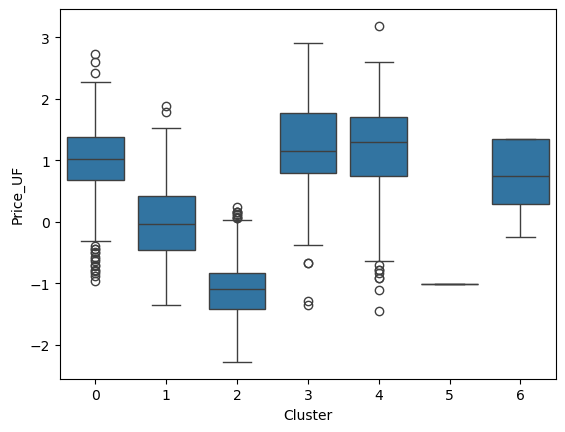

In [241]:
# Observemos la distribucion de precios mediante un boxplot para cada cluster
sns.boxplot(x='Cluster',y='Price_UF',data=df_cluster)
plt.show()

In [242]:
# generemos un dataframe agrupado por cluster y comuna para analizar la preponderancia de algunas comunas a los respectivos clusters
df_cluster_comuna=pd.DataFrame(df_cluster.groupby(by=['Cluster','Comuna']).agg({'Price_UF':['count']}).reset_index().values,columns=['cluster','comuna','cuenta'])

In [243]:
# ordenamos para poder extraer las top comunas de cada cluster
df_cluster_comuna=df_cluster_comuna.sort_values(by=['cluster','cuenta'],ascending=False)

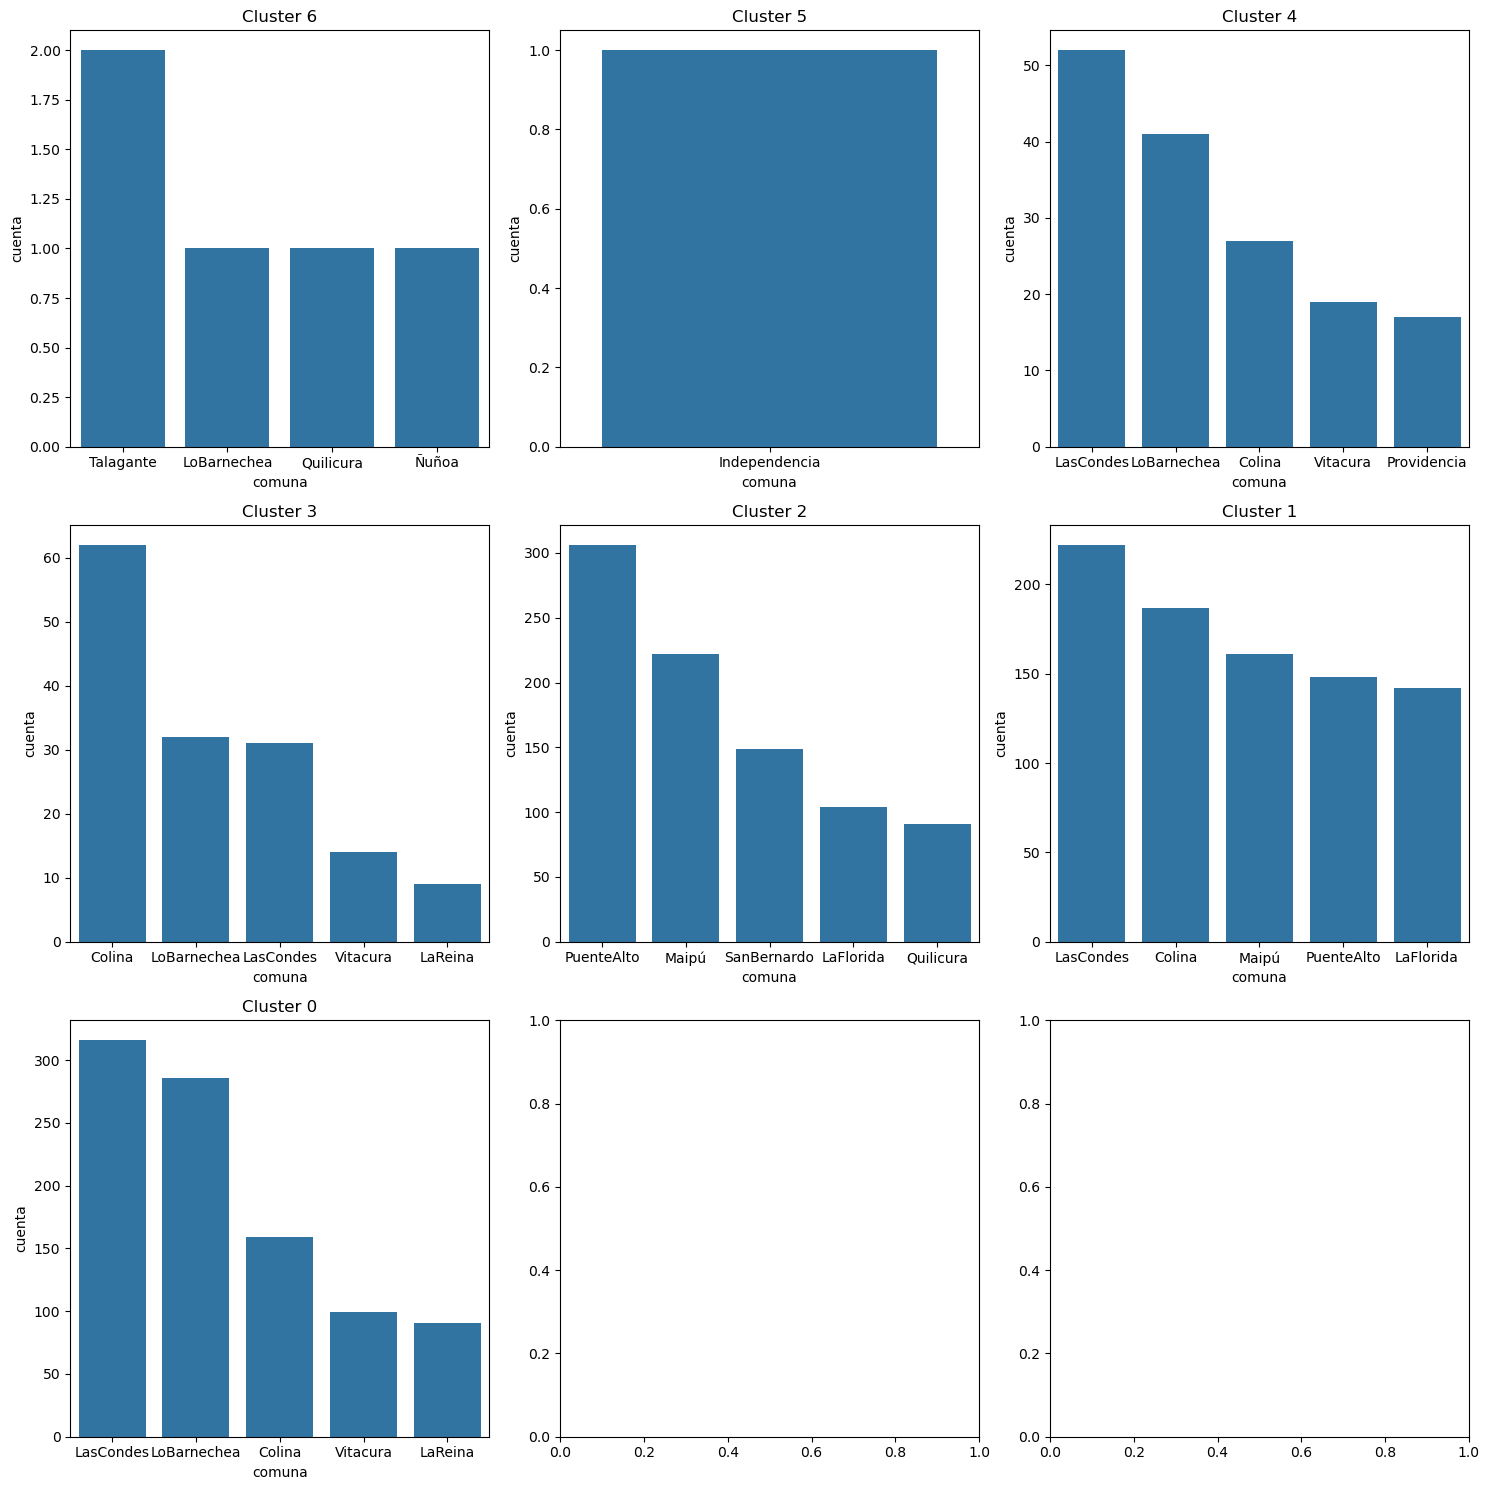

In [245]:
# graficamos en una grilla las top comunas de cada cluster y la cantidad de veces que aparecen
ncols=3
nrows=3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows),tight_layout=True)

axes = axes.flatten()  

for i,cluster_i in enumerate(df_cluster_comuna.cluster.unique()):
    df_cluster_comuna_i=df_cluster_comuna.query(f'cluster == {cluster_i}').head(5)
    sns.barplot(df_cluster_comuna_i, ax=axes[i],x='comuna',y='cuenta')
    axes[i].set_title(f'Cluster {cluster_i}')
